In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP

In [3]:
dataset = DBLP('./data/dblp', transform=T.Constant(node_types='conference'))
data = dataset[0]

In [4]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(334, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 334),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# find the sparse nodes
node_type = 'author'
sparse_threshold = 10
not_sparse = torch.sum(data[node_type].x, 1).to(torch.int) > sparse_threshold



base_data = data['author'].x[not_sparse]
half_data = torch.where(torch.rand_like(base_data) < 0.5, torch.zeros_like(base_data), base_data)

loader = DataLoader(
    TensorDataset(base_data, half_data), 
    batch_size=16, shuffle=True, pin_memory=True)


# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


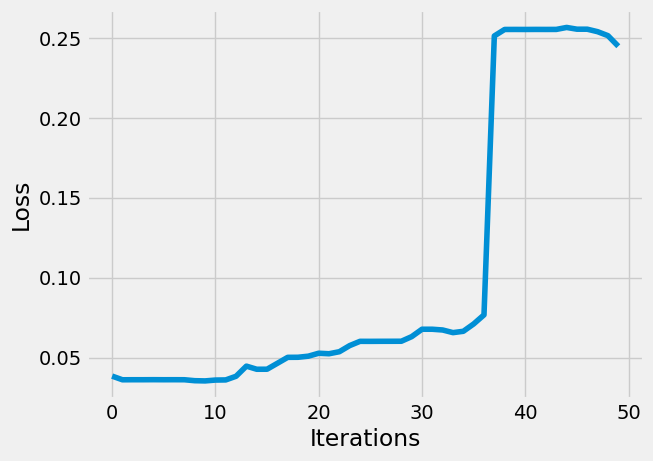

In [11]:
import numpy as np
from tqdm import trange

epochs = 50
outputs = []

average_losses, average_accuracies = [], []
for epoch in trange(epochs):
    epoch_losses, epoch_accuracies = [], []
    for base, half in loader:
      reconstructed = model(base)
      maxed = torch.max(half, reconstructed)
      loss = loss_function(maxed, base)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      accuracy = (torch.round(reconstructed) == base).float().mean()
      epoch_accuracies.append(accuracy) 
      # Storing the losses in a list for plotting
      epoch_losses.append(loss.item())
    average_losses.append(np.mean(epoch_losses))
    average_accuracies.append(np.mean(epoch_accuracies))
    outputs.append((epochs, base, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(average_losses)

In [23]:
dataset[0][0]

TypeError: object of type 'int' has no len()